In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

from util.collision_loss import torch_collision_check, NN_constraint_step
from util.zonotope import Zonotope, TorchZonotope
from util.constrained_zonotope import TorchConstrainedZonotope
from util.NN_con_zono import forward_pass_NN_torch, forward_pass_NN_con_zono_torch

# Neural network collision update

In [2]:
# Toy 2 Layer network
# 2 - 10 - 2

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)  
        self.fc2 = nn.Linear(10, 2)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

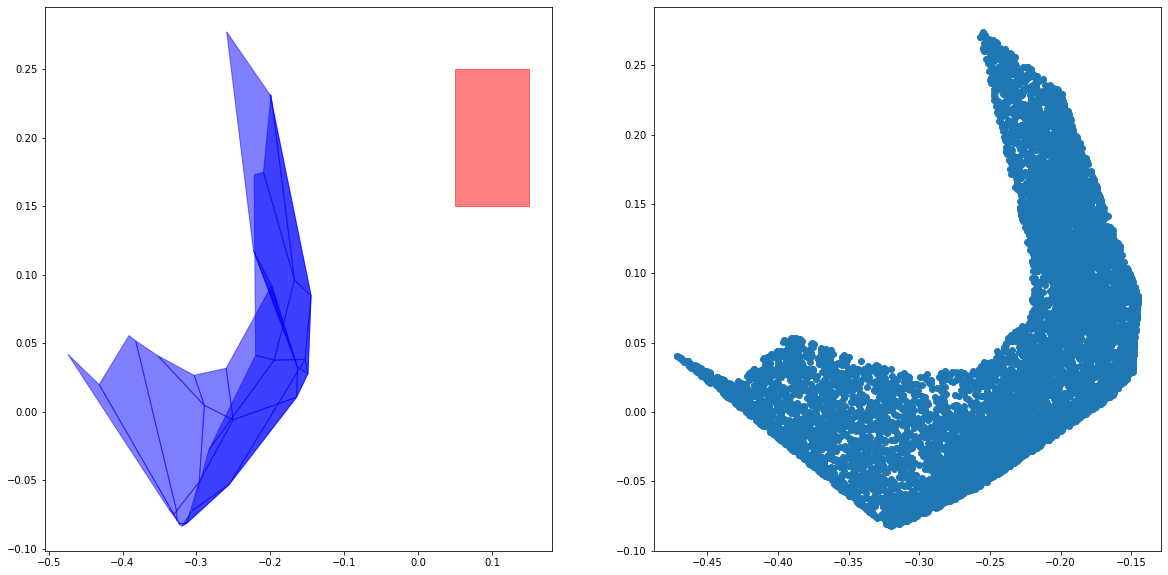

In [3]:
# input zonotope
Z_in = TorchZonotope(torch.zeros(2,1),torch.eye(2))

# output constraint zonotope ("obstacle")
c_obs = torch.tensor([[0.1],[0.2]])
G_obs = torch.diag(torch.tensor([0.05,0.05]))
Z_obs = TorchConstrainedZonotope(c_obs, G_obs)

# compute initial reachable set
Z_out = forward_pass_NN_torch(Z_in, net)

# plot zonotopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for z in Z_out:
    z.plot(ax1)
Z_obs.plot(ax1, 'r')
# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float)
Y_out = net(X_in)
ax2.scatter(Y_out[:,0].detach().numpy(), Y_out[:,1].detach().numpy())

C:\Users\Adam\Anaconda3\envs\reach-net\lib\site-packages\diffcp\cone_program.py:282: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
[[0.25095355 0.27020295 0.2624448  0.24557566]
 [0.36928361 0.37708155 0.37249406 0.36560235]]
[[0.20079721 0.25095354 0.20079734 0.24557564 0.19062631 0.20080198
  0.20079735]
 [0.37515618 0.36928361 0.37515621 0.36560235 0.37188555 0.37515568
  0.37515621]]
[[0.2624448  0.23306218 0.24557567]
 [0.37249406 0.35212022 0.36560237]]
[[0.23306215 0.17424946 0.24557566 0.19062633 0.15575026]
 [0.35212021 0.34686959 0.36560235 0.37188556 0.36288909]]
[[0.15575023 0.14046654 0.15826733 0.17424949]
 [0.3628891  0.43467305 0.39223906 0.34686957]]
[[0.15826733 0.12740793 0.14046653]
 [0.39223905 0.44299315 0.43467305]]
[[0.19005001 0.27020293 0.26244481 0.18035177]
 [0.36271044 0.37708155 0.37249407 0.35792696]]
[[0.19005003 0.15331917 0.14165752 0.18035183]
 [0.36271043 0.34832594 0.34279164 0.35792697]]
[[0.15331919 0.06849971 0.14165748 0.

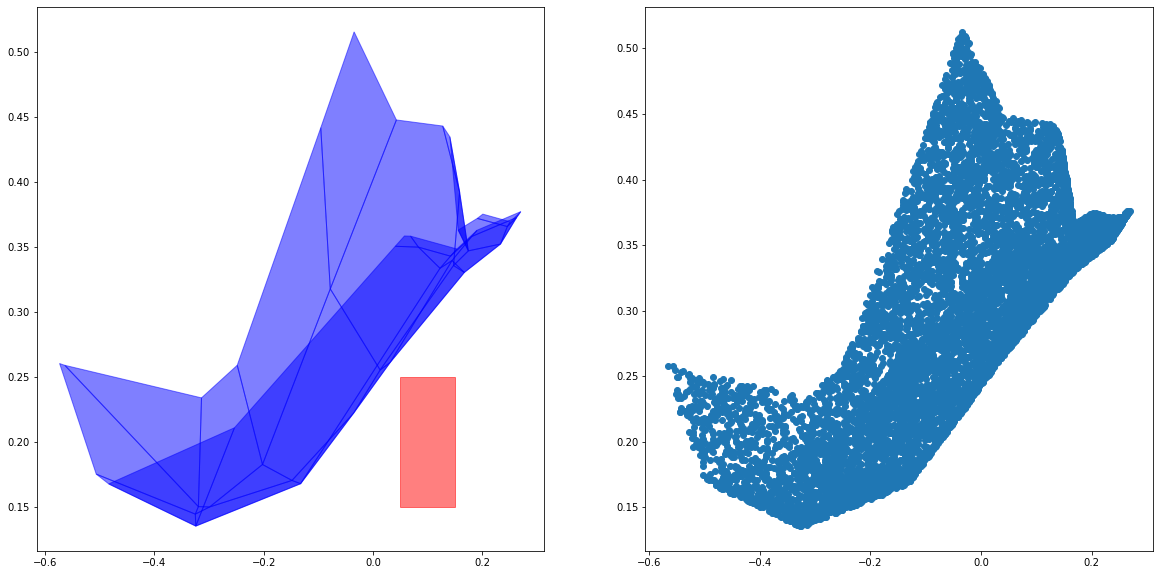

In [4]:
# constraint optimizer
con_opt = optim.SGD(net.parameters(), lr=0.1)

torch.autograd.set_detect_anomaly(True)
# # take a constraint step
NN_constraint_step(Z_in, Z_obs, net, con_opt)

# recompute reachable set
Z_out = forward_pass_NN_torch(Z_in, net)

# plot zonotopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for z in Z_out:
    z.plot(ax1)
Z_obs.plot(ax1, 'r')
# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float)
Y_out = net(X_in)
ax2.scatter(Y_out[:,0].detach().numpy(), Y_out[:,1].detach().numpy())

# Neural network function approximator

In [17]:
# 3 Layer ReLU Feedforward Network
# 2 - 100 - 100 - 2

# n_L1 = 10
# n_L2 = 10

# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(2, n_L2)  
#         self.fc2 = nn.Linear(n_L1, n_L2)
#         self.fc3 = nn.Linear(n_L2, 2)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)  
        self.fc2 = nn.Linear(10, 2)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In [18]:
# Use nonlinear function to generate data
# nonlinear function (vectorized)
def f_nonl(x):
    return np.array([x[:,0]**2 + np.sin(x[:,1]),
                     x[:,1]**2 + np.sin(x[:,0])])

# training set
N_train = 10000
X_train = np.random.uniform(-1, 1, (N_train,2))

# compute y's
Y_train = f_nonl(X_train)

X_train = torch.as_tensor(X_train, dtype=torch.float)
Y_train = torch.as_tensor(Y_train.T, dtype=torch.float)

In [19]:
# test set
N_test = 10000
X_test = np.random.uniform(-1, 1, (N_test,2))

# compute y's
Y_test = f_nonl(X_test)

X_test = torch.as_tensor(X_test, dtype=torch.float)
Y_test = torch.as_tensor(Y_test.T, dtype=torch.float)

In [22]:
# train the network
optimizer = optim.SGD(net.parameters(), lr=0.1)

loss = nn.MSELoss()

num_iters = 1000

# training loop:
for i in range(num_iters):
    optimizer.zero_grad()   # zero the gradient buffers

    pred = net(X_train)

    output = loss(pred, Y_train)
    #print('loss: ', output)
    output.backward()
    optimizer.step() 

Text(0.5, 1.0, 'Y test pred')

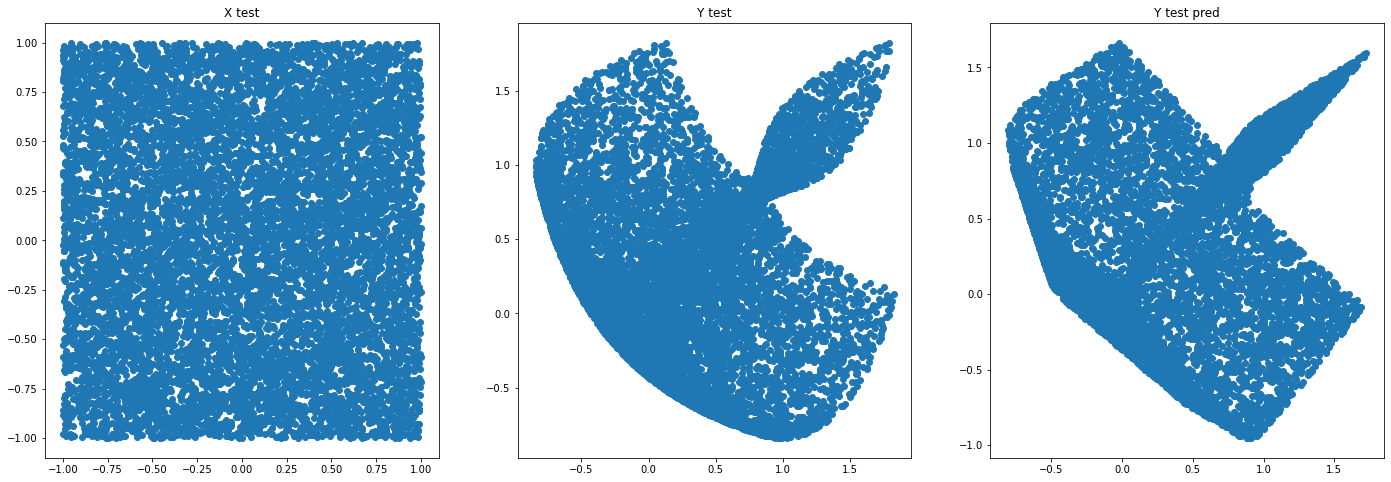

In [23]:
Y_test_pred = net(X_test)
test_loss = loss(Y_test_pred, Y_test)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
ax1.scatter(X_test[:,0], X_test[:,1]); ax1.set_title('X test')
ax2.scatter(Y_test[:,0], Y_test[:,1]); ax2.set_title('Y test')
ax3.scatter(Y_test_pred[:,0].detach().numpy(), Y_test_pred[:,1].detach().numpy()); ax3.set_title('Y test pred')

# Constrained training
Train function approximator under some obstacle constraints

[[ 1.14423682  1.20072267  1.17635294  0.87816942  0.90924404]
 [ 0.20484372 -0.34681784  0.1708061  -0.4497886  -0.03206319]]
[[1.14423661 1.17635288 1.17628686]
 [0.20484368 0.17080599 0.22874473]]
[[ 0.76343195  0.85539012  0.7179709   0.87816951]
 [-0.4975206  -0.48211662 -0.47512792 -0.44978838]]
[[-0.12315296  0.03854357  0.00681792]
 [-0.45460204 -0.48738359 -0.46822157]]
[[ 0.00681789  0.76343183  0.03854357  0.71797086  0.08336758]
 [-0.46822157 -0.49752057 -0.48738361 -0.47512792 -0.4626702 ]]
[[ 0.90924414  0.57786725  0.71797078  0.87816937]
 [-0.03206294 -0.27428469 -0.47512802 -0.44978851]]
[[ 0.0833681   0.57786733  0.71797106]
 [-0.46267013 -0.27428466 -0.47512791]]
[[ 1.14423682  0.95808613  0.90924411]
 [ 0.20484379  0.51870784 -0.03206302]]
[[1.04193372 1.04045835 1.1857931  1.16428099 1.16428086 1.16428096]
 [1.21494896 1.13753564 0.95877775 1.19324447 1.19324466 1.19324454]]
[[1.18579302 1.19010968 1.03086867 1.04045836]
 [0.95877816 0.65846499 1.02812222 1.137536 

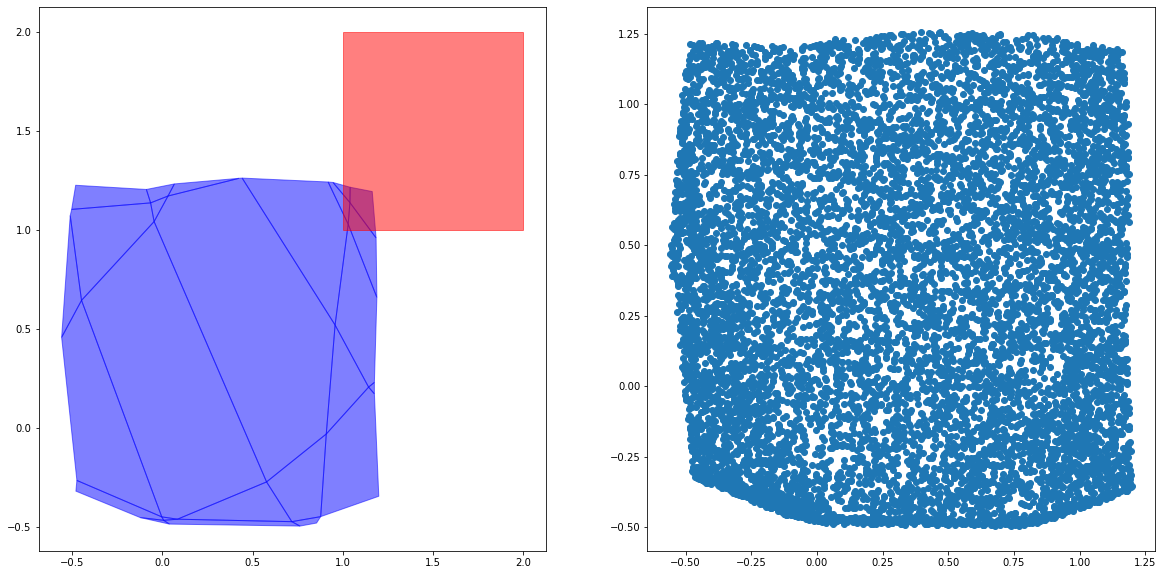

In [15]:
# input zonotope
Z_in = TorchZonotope(torch.zeros(2,1),torch.eye(2))

# output constraint zonotope ("obstacle")
c_obs = torch.tensor([[1.5],[1.5]])
G_obs = torch.diag(torch.tensor([0.5,0.5]))
Z_obs = TorchConstrainedZonotope(c_obs, G_obs)

# compute initial reachable set
Z_out = forward_pass_NN_torch(Z_in, net)

# plot zonotopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for z in Z_out:
    z.plot(ax1)
Z_obs.plot(ax1, 'r')
# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float)
Y_out = net(X_in)
ax2.scatter(Y_out[:,0].detach().numpy(), Y_out[:,1].detach().numpy())

In [36]:
# objective optimizer
obj_opt = optim.SGD(net.parameters(), lr=0.1)

# constraint optimizer
con_opt = optim.SGD(net.parameters(), lr=0.1)

obj = nn.MSELoss()

num_iters = 100

# training loop:
for i in range(num_iters):
    print("iter: ", i)
    # objective update
    obj_opt.zero_grad()   # zero the gradient buffers

    pred = net(X_train)

    obj_loss = obj(pred, Y_train)
    obj_loss.backward()
    obj_opt.step() 

    # constraint update
    NN_constraint_step(Z_in, Z_obs, net, con_opt)

iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
iter:  5
iter:  6
iter:  7
iter:  8
iter:  9
iter:  10
iter:  11
iter:  12
iter:  13
iter:  14
iter:  15
iter:  16
iter:  17
iter:  18
iter:  19
iter:  20
iter:  21
iter:  22
iter:  23
iter:  24
iter:  25
iter:  26
iter:  27
iter:  28
iter:  29
iter:  30
iter:  31
iter:  32
iter:  33
iter:  34
iter:  35
iter:  36
iter:  37
iter:  38
in collision
in collision
iter:  39
in collision
in collision
iter:  40
in collision
iter:  41
in collision
iter:  42
in collision
iter:  43
in collision
iter:  44
in collision
iter:  45
in collision
iter:  46
in collision
iter:  47
in collision
iter:  48
in collision
iter:  49
in collision
iter:  50
in collision
iter:  51
in collision
iter:  52
in collision
iter:  53
in collision
iter:  54
in collision
iter:  55
in collision
iter:  56
in collision
iter:  57
in collision
iter:  58
in collision
iter:  59
in collision
iter:  60
in collision
iter:  61
in collision
iter:  62
in collision
iter:  63
in collision
iter: 

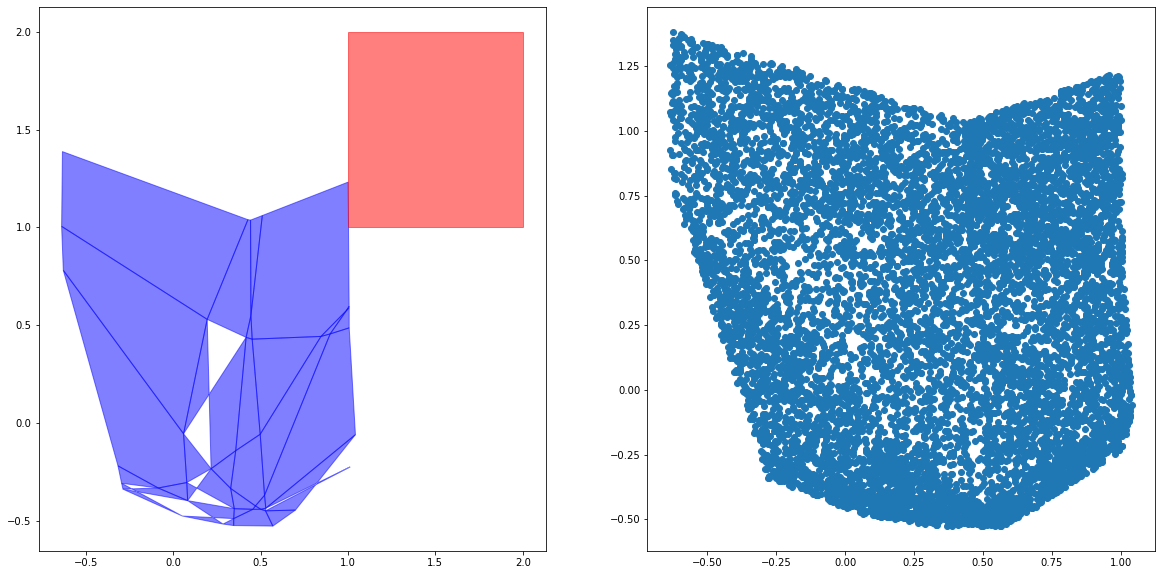

In [37]:
# recompute reachable set
Z_out = forward_pass_NN_torch(Z_in, net)

# plot zonotopes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
for z in Z_out:
    z.plot(ax1)
Z_obs.plot(ax1, 'r')
# plot samples
N_samples = 10000
X_in = np.random.uniform(-1, 1, (N_samples,2))
X_in = torch.as_tensor(X_in, dtype=torch.float)
Y_out = net(X_in)
ax2.scatter(Y_out[:,0].detach().numpy(), Y_out[:,1].detach().numpy())0